In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import zipfile
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Download dataset

In [2]:
!mkdir ol-data
!wget https://github.com/bahategar/DigitalSkola-RFMAnalysis-OnlineRetail-/raw/main/OnlineRetail.zip -P ./ol-data/

--2022-08-11 09:37:28--  https://github.com/bahategar/DigitalSkola-RFMAnalysis-OnlineRetail-/raw/main/OnlineRetail.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bahategar/DigitalSkola-RFMAnalysis-OnlineRetail-/main/OnlineRetail.zip [following]
--2022-08-11 09:37:28--  https://raw.githubusercontent.com/bahategar/DigitalSkola-RFMAnalysis-OnlineRetail-/main/OnlineRetail.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7548702 (7.2M) [application/zip]
Saving to: ‘./ol-data/OnlineRetail.zip’

OnlineRetail.zip    100%[===================>]   7.20M  --.-KB/s    in 0.06s   

2022-08-11 09:37:29

In [3]:
# Load dataset

with zipfile.ZipFile('/content/ol-data/OnlineRetail.zip') as z:
  with z.open('OnlineRetail.csv') as f:
    df = pd.read_csv(f, encoding="ISO-8859-1")

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Data Wrangling

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
(df.isna().sum()/len(df) * 100).sort_values(ascending=False)

CustomerID     24.926694
Description     0.268311
InvoiceNo       0.000000
StockCode       0.000000
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
Country         0.000000
dtype: float64

In [6]:
df.dropna(inplace=True)

In [7]:
df['CustomerID'] = df['CustomerID'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int64         
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.9+ MB


columns description :
* `InvoiceNo` - Invoice number, to identify each invoice
* `StockCode` - Stock code, to identify each item in the inventory
* `Description` - Item's description
* `Quantity` - Number of purchased item in each invoice
* `InvoiceDate` - Date of purchasement
* `UnitPrice` - Item's price per unit
* `CustomerID` - Customer's identification number
* `Country` - Customer's country of origin

In [9]:
# Check unique value 
df[['InvoiceNo','StockCode','CustomerID']].nunique()

InvoiceNo     22190
StockCode      3684
CustomerID     4372
dtype: int64

# Exploratory Data Analysis

In [10]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


Notes :
- Quantity must be positive 
- UnitPrice must be more than zero

In [11]:
# Check anomaly data


print('The data consist of ', 
      str(df[df['Quantity'] < 0]['Quantity'].count()), 
      'rows of data with item quantity less/equal than zero')
print('About {:.2f}% of total data'.format(df[df['Quantity'] < 0]['Quantity'].count()/len(df) * 100))
print('\nThe data consists of', 
      str(df[df['UnitPrice'] == 0]['UnitPrice'].count()),
      'rows of data with unit price equal to zero')
print('About {:.2f}% of total data'.format(df[df['UnitPrice'] == 0]['UnitPrice'].count()/len(df) * 100))

The data consist of  8905 rows of data with item quantity less/equal than zero
About 2.19% of total data

The data consists of 40 rows of data with unit price equal to zero
About 0.01% of total data


In [12]:
# Remove anomaly data
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int64         
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.3+ MB


In [13]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453
std,179.331775,22.097877,1713.141560
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


In [14]:
# Check unique value 
df[['InvoiceNo','StockCode','CustomerID']].nunique()

InvoiceNo     18532
StockCode      3665
CustomerID     4338
dtype: int64

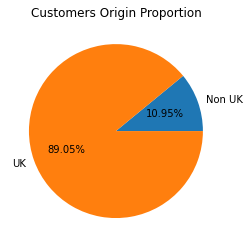

In [18]:
df['Country_isUK'] = np.where(df['Country'] == 'United Kingdom', 'UK', 'Non UK')

customer_origin = df.groupby(['Country_isUK']).size()

plt.title('Customers Origin Proportion')
plt.pie(customer_origin, labels=customer_origin.index, autopct= lambda p: f'{p:.2f}%')
plt.show()

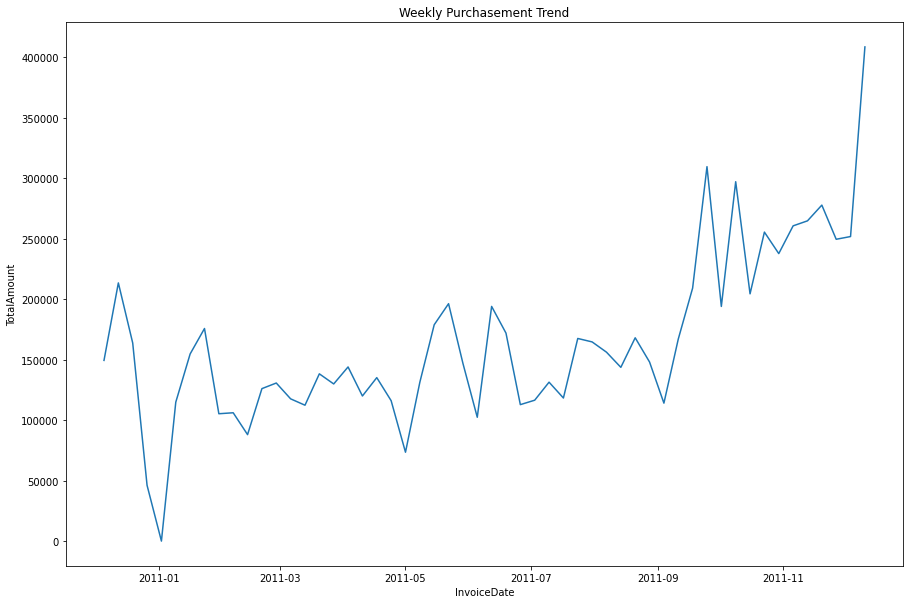

In [19]:
# Plot weekly trend

df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(by=pd.Grouper(key='InvoiceDate', freq='1W'))['TotalAmount'].sum()

plt.figure(figsize=(15, 10))
plt.title('Weekly Purchasement Trend')
sns.lineplot(x=weekly_purchasements.index, y=weekly_purchasements)
plt.show()

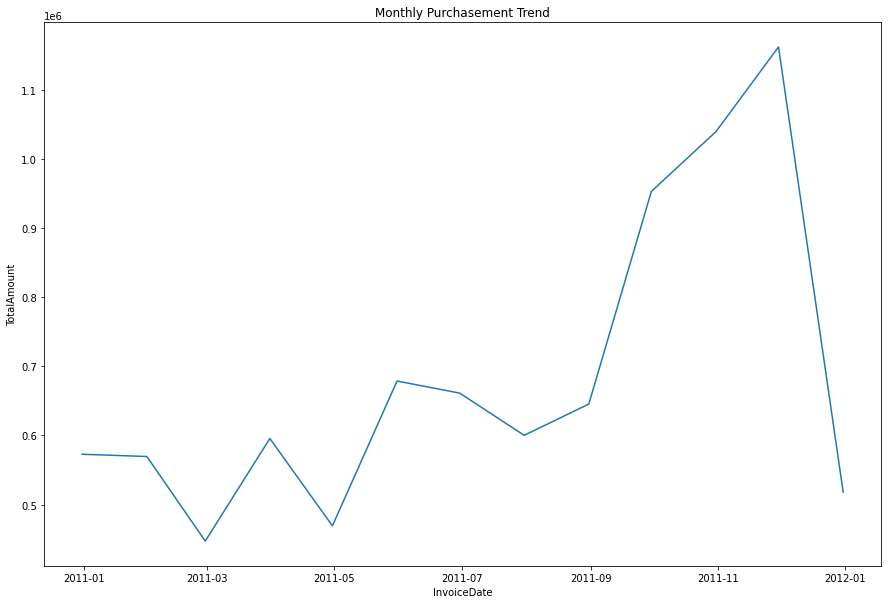

In [21]:
# Plot monthly trend
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key='InvoiceDate', freq='1M'))['TotalAmount'].sum()

plt.figure(figsize=(15, 10))
plt.title('Monthly Purchasement Trend')
sns.lineplot(x=monthly_purchasements.index, y=monthly_purchasements)
plt.show()

# RFM Analysis

## Recency Analysis

In [26]:
recency = df.groupby(['CustomerID'])['InvoiceDate'].max()
recency = max(recency) - recency
recency = recency.dt.days # in days
recency = recency.rename('Recency (in days)')

recency.head()

CustomerID
12346    325
12347      1
12348     74
12349     18
12350    309
Name: Recency (in days), dtype: int64

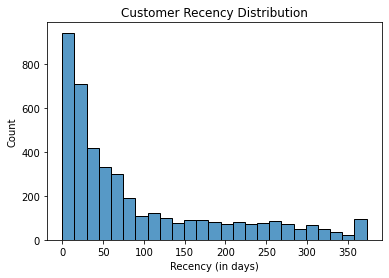

In [30]:
plt.title('Customer Recency Distribution')
sns.histplot(recency)
plt.show()

## Frequency Analysis

In [31]:
freq = df.groupby(['CustomerID'])['InvoiceNo'].count()
freq = freq.rename('Frequency')

freq.head()

CustomerID
12346      1
12347    182
12348     31
12349     73
12350     17
Name: Frequency, dtype: int64

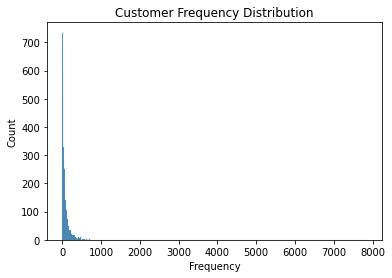

In [32]:
plt.title('Customer Frequency Distribution')
sns.histplot(freq)
plt.show()

## Monetary

In [33]:
monetary = df.groupby(['CustomerID'])['TotalAmount'].sum()
monetary = monetary.rename('Monetary')

monetary.head()

CustomerID
12346    77183.60
12347     4310.00
12348     1797.24
12349     1757.55
12350      334.40
Name: Monetary, dtype: float64

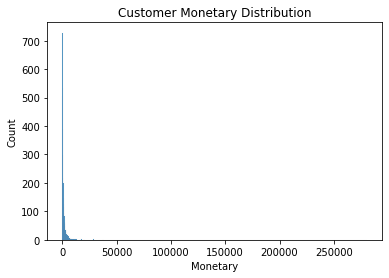

In [34]:
plt.title('Customer Monetary Distribution')
sns.histplot(monetary)
plt.show()

# Customer Segmentation

In [36]:
# Get customer's country of origin
country = df.groupby(['CustomerID', 'Country_isUK']).size().reset_index().drop(0, axis = 1)

# Merge the data
df_new = country \
    .merge(recency, on = 'CustomerID') \
    .merge(freq, on = 'CustomerID') \
    .merge(monetary, on = 'CustomerID')

# Set CustomerID as index
df_new = df_new.set_index('CustomerID')

df_new.head()

,Country_isUK,Recency (in days),Frequency,Monetary
CustomerID,,,,
12346,UK,325,1,77183.60
12347,Non UK,1,182,4310.00
12348,Non UK,74,31,1797.24
12349,Non UK,18,73,1757.55
12350,Non UK,309,17,334.40


## Data preprocessing

In [37]:
# OneHotEncoding

df_new = pd.get_dummies(df_new, columns=['Country_isUK'], drop_first=True)
df_new = df_new.rename(columns = {'Country_isUK_UK': 'Country_UK'})

df_new.head()

,Recency (in days),Frequency,Monetary,Country_UK
CustomerID,,,,
12346,325,1,77183.60,1
12347,1,182,4310.00,0
12348,74,31,1797.24,0
12349,18,73,1757.55,0
12350,309,17,334.40,0


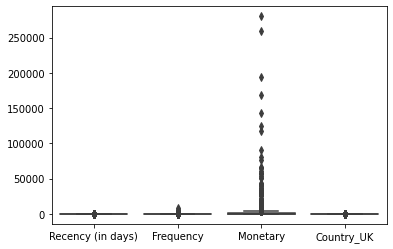

In [40]:
sns.boxplot(data=df_new)
plt.show()

In [39]:
# Scale the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)

df_scaled = pd.DataFrame(df_scaled, columns = df_new.columns, index = df_new.index)

df_scaled.head()

,Recency (in days),Frequency,Monetary,Country_UK
CustomerID,,,,
12346,2.334574,-0.396578,8.358668,0.326547
12347,-0.905340,0.394649,0.250966,-3.062350
12348,-0.175360,-0.265435,-0.028596,-3.062350
12349,-0.735345,-0.081836,-0.033012,-3.062350
12350,2.174578,-0.326635,-0.191347,-3.062350


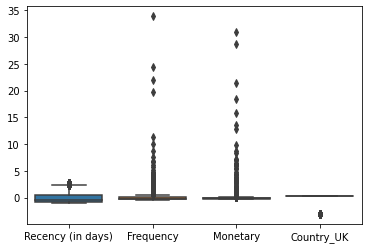

In [42]:
sns.boxplot(data=df_scaled)
plt.show()

## Modeling

In [43]:
# Determining the best number of cluster
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = []

for k in possible_k:
    kmeans = KMeans(n_clusters = k, random_state = 123).fit(df_scaled)
    
    silhouette.append(silhouette_score(X = df_scaled, labels = kmeans.labels_))

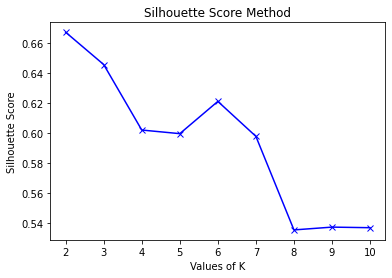

In [44]:
# Plot the score
plt.plot(possible_k, silhouette, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

According to the graph, chose 6

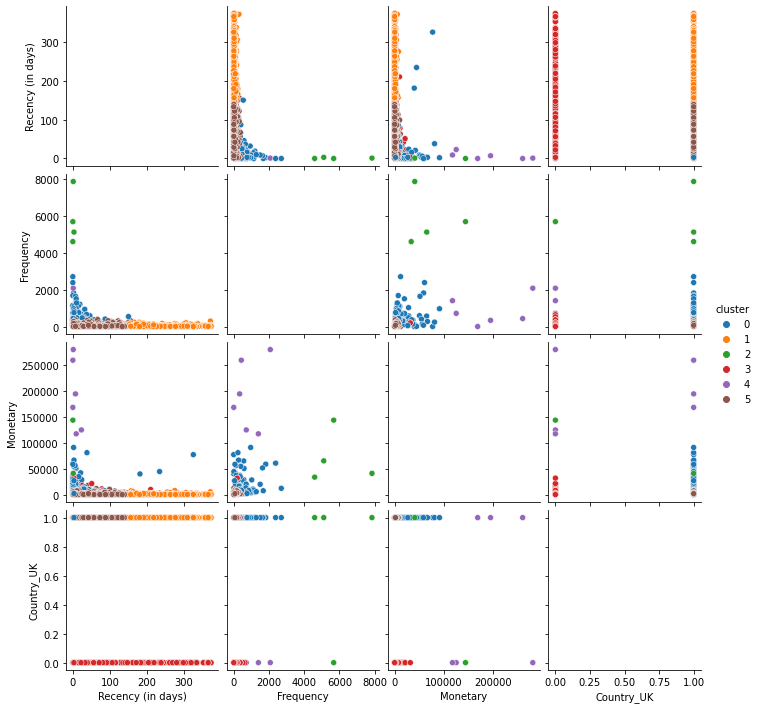

In [45]:
kmeans = KMeans(n_clusters = 6, random_state = 123).fit(df_scaled)

df_result_kmeans = df_new.copy()
df_result_kmeans['cluster'] = kmeans.labels_

sns.pairplot(data = df_result_kmeans, hue = 'cluster', diag_kind = 'None', palette = 'tab10')
plt.show()

In [46]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
df_result_kmeans \
    .drop("Country_UK", axis = 1) \
    .groupby('cluster') \
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max']) \
    .transpose()

cluster                              0            1              2  \
Recency (in days) mean       15.234973   246.776618       1.000000   
                  std        35.305176    65.636727       1.414214   
                  min         0.000000   143.000000       0.000000   
                  q25         2.000000   189.000000       0.000000   
                  median      6.000000   242.000000       0.500000   
                  q75        16.000000   296.000000       1.500000   
                  max       325.000000   373.000000       3.000000   
Frequency         mean      535.360656    27.689979    5807.000000   
                  std       358.078267    32.176026    1429.730044   
                  min         1.000000     1.000000    4595.000000   
                  q25       367.000000     8.250000    4982.000000   
                  median    450.000000    18.000000    5393.000000   
                  q75       589.500000    33.000000    6218.000000   
                  max      2700.000000   297.000000    7847.000000   
Monetary          mean    13085.065738   450.793070   70925.287500   
                  std     16313.461152   610.367153   50424.336433   
                  min      1093.650000     3.750000   33719.730000   
                  q25      4014.945000   163.225000   39173.610000   
                  median   6923.130000   305.515000   53078.180000   
                  q75     13213.210000   505.542500   84829.857500   
                  max     91062.380000  7832.470000  143825.060000   

cluster                              3              4             5  
Recency (in days) mean       95.405797       6.666667     42.676884  
                  std       104.638705       8.869423     36.313016  
                  min         0.000000       0.000000      0.000000  
                  q25        18.000000       0.250000     14.000000  
                  median     52.000000       4.000000     31.000000  
                  q75       136.500000       8.500000     64.000000  
                  max       373.000000      23.000000    155.000000  
Frequency         mean       81.396135     826.833333     76.270826  
                  std        96.304061     771.620481     74.030983  
                  min         1.000000       3.000000      1.000000  
                  q25        21.250000     360.500000     22.000000  
                  median     45.000000     572.500000     51.000000  
                  q75       101.000000    1228.500000    107.000000  
                  max       638.000000    2076.000000    385.000000  
Monetary          mean     2262.538913  190863.461667   1341.293935  
                  std      3479.689136   67791.993010   1592.871914  
                  min        51.560000  117379.630000      6.200000  
                  q25       459.650000  135804.022500    371.700000  
                  median   1025.700000  181511.645000    795.120000  
                  q75      2659.962500  243380.672500   1720.300000  
                  max     31906.820000  280206.020000  17654.540000

In [49]:
df_result_kmeans.head()

,Recency (in days),Frequency,Monetary,Country_UK,cluster
CustomerID,,,,,
12346,325,1,77183.60,1,0
12347,1,182,4310.00,0,3
12348,74,31,1797.24,0,3
12349,18,73,1757.55,0,3
12350,309,17,334.40,0,3
